<h1>
      <h4>
          <p style="font-size:36pt">MSIN0114</p> 
          &nbsp;
          &nbsp;
          <p style="font-size:30pt">Product Recommender System for MVP with Fine-tuning and Sentiment Analysis </p>
      </h4>
</h1>


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Table of Contents
* [1. Data Preparation](#1.-Data-Preparation)
    * [1.1 Data Overview](#1.1-Data-Overview) 
    * [1.2 Data Cleaning](#1.2-Data-Cleaning)
      * [1.2.1 Product](#1.2.1-Product)
      * [1.2.2 Payment](#1.2.2-Payment)
      * [1.2.3 Reviews](#1.2.3-Reviews)
      * [1.2.4 Users](#1.2.4-Users)
      * [1.2.5 Combination](#1.2.4-Combination)
* [2. Data Visualisation](#2.-Data-Visualisation)
    * [2.1 Correlation Matrix](#2.1-Correlation-Matrix) 
    * [2.2 Merchant and Products](#2.2-Merchant-and-Products)
    * [2.3 Category](#2.3-Category) 
    * [2.4 Payment Event](#2.4-Payment-Event)    
* [3. Recommender System](#3.-Recommender-System)
    * [3.1 Content Based Filtering](#3.1-Content-Based-Filtering)
      * [3.1.1 TFIDF Based](#3.1.1-TFIDF-Based) 
      * [3.1.2 Metadata Based](#3.1.2-Metadata-Based)     
    * [3.2 Data Simulation](#3.1-Data-Simulation)
      * [3.2.1 Rating Distribution](#3.2.1-Rating-Distribution)     
    * [3.3 Collaborative Filtering](#3.3-Collaborative-Filtering)
      * [3.3.1 Cleaning Data](#3.3.1-Cleaning-Data) 
      * [3.3.2 Data Preparation](#3.3.2-Data-Preparation)
      * [3.3.3 Model Parameters](#3.3.3-Model-Parameters) 
      * [3.3.4 Models Comparation](#3.3.4-Models-Comparation)
      * [3.3.5 Hyperparameter Tuning](#3.3.5-Hyperparameter-Tuning)
        * [3.3.5.1 Matrix Factorization](#3.3.5.1-Matrix-Factorization)
        * [3.3.5.2 KNN Models without Baseline](#3.3.5.2-KNN-Models-without-Baseline)
        * [3.3.5.3 KNN Models with Baseline](#3.3.5.3-KNN-Models-with-Baseline)
        * [3.3.5.4 KNN Models Results](#3.3.5.4-KNN-Models-Results)
      * [3.3.6 Model Based Recommendation System](#3.3.6-Model-Based-Recommendation-System) 

# 1. Data Preparation 

Overall, all the datasets from company have lots of missing value and most of files are empty. And here are three datasets contains the most comprehensive information will be selected out to engage the project, which renamed as: **product, payment, reviews**.

## 1.1 Data Overview

In [1]:
# Display full output rather than just the last line of output

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Necessary code and modules for the assignment 
import pandas as pd
import numpy as np 
import json

# Plot 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS

from collections import ChainMap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Text analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Import models
import string
import nltk
import re
from zhon.hanzi import punctuation as ch_pun
from langdetect import detect

from random import choices
import os
import csv

#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Surprise library
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import Reader

from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import BaselineOnly
from surprise import CoClustering

from surprise.similarities import \
    cosine, msd, pearson, pearson_baseline
from surprise.model_selection import \
    train_test_split, GridSearchCV, cross_validate

In [3]:
# Load csv files
product = pd.read_csv('/Users/mandyz/Desktop/Data_GW/ananke_public_products.csv')
payment = pd.read_csv('/Users/mandyz/Desktop/Data_GW/minotaur_public_payment_events.csv')
reviews = pd.read_csv('/Users/mandyz/Desktop/Data_GW/ananke_public_product_reviews.csv')
users= pd.read_csv('/Users/mandyz/Desktop/Data_GW/rhea_public_customers.csv')

In [4]:
# Check the shape
product.shape
payment.shape
reviews.shape 
users.shape

(528, 42)

(37189, 6)

(35, 8)

(450, 8)

The datasets contains the following features:

> product:
- product_id: a unique identifier for each product. 
- merchant_id: a unique identifier for each merchant. 
- sku: (stock-keeping unit) is a scannable bar code. 
- description: instruction for each product. 

> payment: 
- event_id: a unique even for each transaction. 
- event_type: a type of transaction stage.

> reviews: 
- user_id: a user identified with a unique id. 
- rating: rating of the corresponding product by the corresponding user. 
- timestamp: time of the rating. 

## 1.2 Data Cleaning

### 1.2.1 Product

In [5]:
# Viewing the first five lines of Product dataset 
product.head()

,product_id,merchant_id,sku,name,description,category,brand,collection,commodity_type,dimensions_weight,...,updated,details,logo_id,sub_category,default_file_id,size_map_file_id,preview,published_by,max_green_coins_percentage,search_tokens
0,9abf4537-3d98-4f57-9aa4-aa65c26169a8,246f2c3f-b3af-49e8-b53c-76c3a9a4485b,NaN,Agaricus Blazei Mushroom Extract Powder (10:1),\nTHE REASONS PEOPLE CHOOSE AGARICUS:&gt;&gt; ...,Health & Beauty,ENRICHD SUPERFOODS,NaN,PHYSICAL,282.0,...,21:06.3,"<html><head><meta name=""viewport"" content=""wid...",NaN,NaN,746f6ea7-b7ef-4937-9876-6a15b82e2e6b,NaN,NaN,NaN,0.0,'/pmc/articles/pmc3168293/':348 '/www.ncbi.nlm...
1,37c9ebce-9f8a-46f2-b13f-5fcb2fde0c5c,9e2c4da3-6f0b-47d6-8809-46cfde958aa4,1,wdqw,sdsadfsfsdf,Ethical Fashion,Ethcs,NaN,PHYSICAL,100.0,...,59:37.7,"<html>\n <head>\n <meta name=""vi...",89a86561-6d9d-43c1-a8ba-9522a7f24072,NaN,NaN,NaN,NaN,NaN,5.0,'sdsadfsfsdf':2 'wdqw':1
2,29605c38-e695-4752-8a65-8d1f831f9308,823f84e8-ba1a-4fc3-a9fe-36b92480c29f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a4fb126d-8649-4131-8218-c164ee707dbe,035ab3e1-ec94-40a6-8603-9df2abd8a75d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,362c5608-90ed-42a4-8008-7a37b623a859,823f84e8-ba1a-4fc3-a9fe-36b92480c29f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Rename the column 
product.rename(columns={'description':'product_instruction'}, inplace=True)

# Unify the unit of weight
for x in range(product.shape[0]):
    obs = product.loc[[x]]
    if obs['dimensions_weight_unit'].values =='g':
        obs['dimensions_weight']/=1000
        product.update(obs)
        
# Replace g with KG 
product.dimensions_weight_unit.replace(['g'],'KG', inplace=True)

# Replace Nan with Unknown
product.category.replace(['nan'],'Unknown',inplace=True)

In [7]:
product_tfidf=product.copy()

In [8]:
# # Check all the columns name in product dataset 
# for col in product.columns:
#     print(col)

In [9]:
# # Drop unnecessary columns 
# product.drop(['sku','collection','commodity_type','dimensions_length','dimensions_width','dimensions_height','dimensions_size_unit',
#               'price_discount_percentage','price_discount_start_time','price_discount_end_time','stock_type','website_url','created','updated',
#               'details','logo_id','sub_category','default_file_id','size_map_file_id','preview','published_by','sub_category'], inplace=True, axis = 1)

### 1.2.2 Payment

The column of **event_data** are string data which contains lots of infomation. In order to explore more information, the data will be transfer into dictionary and then converted into columns. 

In [10]:
# Viewing the first five lines of Payment dataset 
payment.head()

,event_id,stream_id,version,event_type,date_processed,event_data
0,169b7173-033b-4365-924c-9c525e45c664,a90ddd3e-3012-4e70-9880-cd08506f9ae3,1,PAY_REQUESTED,47:07.1,"{""mid"": ""109495"", ""amount"": 2099, ""version"": 1..."
1,c20a46e7-318a-432c-8a4a-a8b6c0c6126a,adb30c82-3c1e-488d-aebf-a6e54b931d32,2,CARD_DETAILS_RETRIEVED,11:52.7,"{""card"": {""brand"": ""Visa"", ""country"": """", ""las..."
2,13ef0e1e-472a-4ac6-9e72-936af0a02296,a90ddd3e-3012-4e70-9880-cd08506f9ae3,2,CARD_DETAILS_RETRIEVED,47:08.6,"{""card"": {""brand"": ""Visa"", ""country"": """", ""las..."
3,3b5dfc0f-2e20-4d24-89ff-7d98109247c5,5339cdee-0bb0-4dea-8783-ba2b5931b4f5,2,CARD_DETAILS_RETRIEVED,15:01.8,"{""card"": {""brand"": ""Visa"", ""country"": """", ""las..."
4,fc084af9-ceec-4b36-aa06-29e72ab231d6,f4c3ad74-8582-4b88-bbaf-ba251919dddd,1,PAY_REQUESTED,51:24.2,"{""mid"": ""109495"", ""amount"": 2099, ""version"": 1..."


In [11]:
payment['event_type'].value_counts()

CARD_DETAILS_RETRIEVED         7859
ACQUIRER_DECISION_COMPLETED    7832
PAY_REQUESTED                  7105
PAY_COMPLETED                  5943
FRAUD_REVIEW                   3158
AUTHORISATION_REQUESTED         966
AUTHORISATION_COMPLETED         794
PAY_PENDING                     775
PAY_FAILED                      634
CANCEL_REQUESTED                621
CANCEL_COMPLETED                458
FULFILL_PAYMENT                 249
CAPTURE_REQUESTED               205
CAPTURE_COMPLETED               189
AUTHORISATION_FAILED            149
CANCEL_FAILED                   107
REFUND_REQUESTED                 71
REFUND_FAILED                    49
REFUND_COMPLETED                 14
CAPTURE_FAILED                   10
AUTHORISATION_PENDING             1
Name: event_type, dtype: int64

In [12]:
# Rewirte the payment taking only 'pay_requested'
payment = payment[payment.event_type == "PAY_REQUESTED"]

In [13]:
# Convert string to dict
payment.event_data = payment.event_data.apply(json.loads)

In [14]:
# Split dictionary into columns
new_columns = pd.json_normalize(payment['event_data'])

# Concatenate dataframes
payment = pd.concat([payment, new_columns], axis=1).drop('event_data', axis=1)

In [15]:
# Define unpacking function
def unpack(some_list):
    unpacked = dict(ChainMap(*some_list[::-1]))
    return unpacked

In [16]:
# Cleaning
payment = payment.dropna(subset=['customer_items'])

In [17]:
# Unpack list
payment['customer_items'] = payment['customer_items'].apply(unpack)

In [18]:
# Split dictionary into columns
new_columns = pd.json_normalize(payment['customer_items'])

# Concatenate dataframes
payment = pd.concat([payment, new_columns], axis=1).drop('customer_items', axis=1)

# Cleaning
payment = payment.dropna(subset=['product_id'])

In [19]:
# for col in payment.columns:
#     print(col)

### 1.2.3 Reviews

In [20]:
# Viewing the first five lines of Reviews dataset 
reviews.head()

,id,product_id,user_id,rating,title,description,created,nick_name
0,9be44360-9cea-47f3-b4e8-7b7c40d23835,529a312a-23ff-4454-8c8c-1349bd8f364f,8deb147f-fff3-4fa5-9c8c-f659b0d072cf,4,Amazing product,Super soft.,28:59.6,Rudi Luis
1,2e01123f-6b86-4de1-aac6-cae336b31942,e3536d24-a23f-410b-b443-51f3231889b7,0a98e375-6dd0-4fa7-920e-c43e10ca7dd4,5,great product!,Thank you!,08:45.6,Bashir Khairy
2,2e197cfd-20a5-4784-adc7-4b44d8d2734d,e3536d24-a23f-410b-b443-51f3231889b7,59c56c4a-0895-411c-9382-306da6deb83a,4,Love these shoes!,Fantastic.,59:44.8,Charlie Freeman
3,f6584604-4d41-434d-a91c-05585a6da910,08a5e75b-68ba-4d0a-b128-1cae859a69bc,59c56c4a-0895-411c-9382-306da6deb83a,5,Great product!,Love it.,02:48.8,Charlie Freeman
4,7f49ebfe-d3c5-4a1d-a27d-68a5fb33bcef,593736b2-d670-4457-ac57-b7c3d4083def,72e3fdcd-5420-4522-9556-d38a35facaa6,4,jg,Kuhl kJ him,11:28.0,Rudi Luis


In [21]:
# Change the column name 
reviews.rename(columns={'description':'user_reviews'}, inplace=True)

In [22]:
# Keep part of columns
reviews= reviews.iloc[:,1:5]

In [23]:
# # Check all the columns name in reviews dataset 
# for col in reviews.columns:
#     print(col)

### 1.2.4 Users 

In [24]:
users.head()

,customer_id,phone,email,kyc_status,kyc_verification_id,first_name,last_name,business_id
0,ab3252ee-0cfe-46be-add7-1e46982dbdaa,74cabd50f4a71fa175f848a515e1c8c0dee352584293d5...,1ac92657f150c86c1fd30530cf456eefba1022f02dd3de...,NaN,NaN,NaN,NaN,NaN
1,da04b5bf-9c29-476f-983c-92a79a3794c2,7a6851ae08ef0da2bccbb87ba50cc1fe6634c85649a804...,611e79a929e5cc53888ecba8ff5dd2a8fd5ee520146c75...,NaN,NaN,NaN,NaN,NaN
2,1e0abedc-c1d3-4547-abb0-ac6962fa9587,5fd26e836a09ae2dc3dcb936a987ea6b2d140b02eb052f...,b30c313f563c6c85fc88a19ca7113add828d924a1095c7...,NaN,NaN,NaN,NaN,NaN
3,1c62d07d-608a-4555-82cc-59602be89f65,bec19a8f06542c985162533e8734946f1ef13b4a51ed95...,1ac92657f150c86c1fd30530cf456eefba1022f02dd3de...,NaN,NaN,NaN,NaN,NaN
4,eefd55c5-a4a6-4f23-993a-0453cca4bdb8,d2a9407e9a4e86b950542d3cd48addefe8f877dcd856b2...,1e666f73eb4fbb592a15cb8668c387dccda84fdc66a856...,NaN,NaN,NaN,NaN,NaN


### 1.2.5 Combination 

In [25]:
# # Appending multiple Dataframe
# combine=product.append([payment, reviews])

In [26]:
# combine.head()

# 2. Data Visualisation

Here is a correlation matrix shows the correlation among all the float varibales within **product**. Firstly, we can see price_amount and price_vat is significantly correlated with each other which is common sense. 

In [27]:
#Check for missing values
print('Number of missing values across columns: \n',
      product.isnull().sum())

Number of missing values across columns: 
 product_id                      0
merchant_id                     0
sku                           431
name                           93
product_instruction           133
category                      104
brand                         141
collection                    527
commodity_type                 92
dimensions_weight              91
dimensions_weight_unit         91
dimensions_length             321
dimensions_width              321
dimensions_height             321
dimensions_size_unit          526
deals                           0
price_amount                   91
price_currency                 91
price_vat                     195
price_discount_type            93
price_discount_amount          93
price_discount_vat            218
price_discount_percentage     324
price_discount_start_time     270
price_discount_end_time       270
manage_stock                    0
stock_type                    269
stock_total                    91
stock

In [28]:
# plt.figure(figsize=(24, 17))
# ax = sns.heatmap(corrmat.corr(), annot=True, cmap="mako", fmt='.2f', annot_kws={"size":12})
# _ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 16)
# _ = ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 16);

<AxesSubplot:>

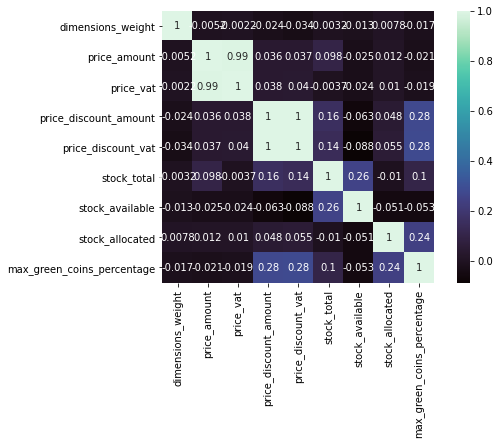

In [29]:
# Prepare the correlation matrix for plotting.
corrmat = product[['dimensions_weight','price_amount','price_vat','price_discount_amount',
'price_discount_vat','stock_total','stock_available','stock_allocated',
                   'max_green_coins_percentage']].corr()

# Plot correlation matrix
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corrmat,cmap='mako',square=True,annot=True)
plt.show()

### Merchant and products 

**Unique merchant and products**

In [30]:
# Count the number of unique merchant and products 
print("Total data ")
print("-"*50)
print("\nTotal Number of merchant   :", len(np.unique(product.merchant_id)))
print("Total No of products  :", len(np.unique(product.product_id)))

Total data 
--------------------------------------------------

Total Number of merchant   : 37
Total No of products  : 528


**Analyzing the products**

In [31]:
# Analysis of products given by the merchant 
Number_of_products_per_merchant = product.groupby(by='merchant_id')['product_id'].count().sort_values(ascending=False)
Number_of_products_per_merchant.head()

merchant_id
9e2c4da3-6f0b-47d6-8809-46cfde958aa4    195
823f84e8-ba1a-4fc3-a9fe-36b92480c29f    189
d1330bb2-9277-4b15-956c-b8f1629a1871     33
d601de5f-546e-416a-8ef6-6c650ed13e90     17
d9ce8296-7546-4be0-b360-cef719de8ee5     12
Name: product_id, dtype: int64

In [32]:
Number_of_category_per_merchant = product.groupby(by='merchant_id')['category'].value_counts().sort_values(ascending=False)
Number_of_category_per_merchant.head(20)

merchant_id                           category             
9e2c4da3-6f0b-47d6-8809-46cfde958aa4  Health & Beauty          133
823f84e8-ba1a-4fc3-a9fe-36b92480c29f  Ethical Fashion           74
                                      Health & Beauty           25
d1330bb2-9277-4b15-956c-b8f1629a1871  Ethical Fashion           25
9e2c4da3-6f0b-47d6-8809-46cfde958aa4  Ethical Fashion           23
823f84e8-ba1a-4fc3-a9fe-36b92480c29f  Accessories               18
                                      Plant-based Nutrition     18
                                      Apparel                   11
7856e6b5-49e1-4cfb-9bc6-3341244e41e4  Plant-based Nutrition      9
d1330bb2-9277-4b15-956c-b8f1629a1871  Accessories                8
823f84e8-ba1a-4fc3-a9fe-36b92480c29f  Organics                   7
d601de5f-546e-416a-8ef6-6c650ed13e90  Apparel                    7
32050f72-5ed3-4c1e-809d-fef3f670a524  Health & Beauty            6
d9ce8296-7546-4be0-b360-cef719de8ee5  Ethical Fashion            6
bd

<AxesSubplot:xlabel='merchant_id'>

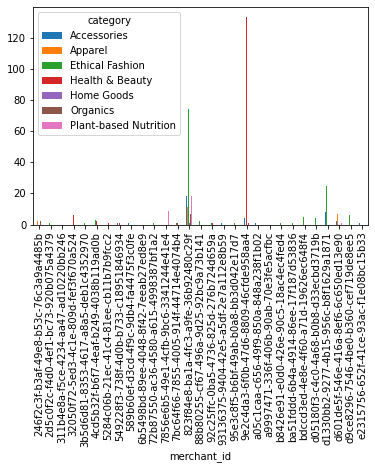

In [33]:
pd.crosstab(product['merchant_id'],product['category']).plot.bar()

The issued products mainly hold by two merchants with diversified categories. Health & Beauty is the main product for the merchant who issued the most products. The second largest mainly sell Ethical Fashion. 

### Category 

In [34]:
product.category.value_counts()

Health & Beauty          174
Ethical Fashion          153
Accessories               38
Plant-based Nutrition     28
Apparel                   20
Organics                  10
Home Goods                 1
Name: category, dtype: int64

<Figure size 720x360 with 0 Axes>

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Products for each Category')

Text(0, 0.5, 'Total number of categories')

Text(0.5, 0, 'Category')

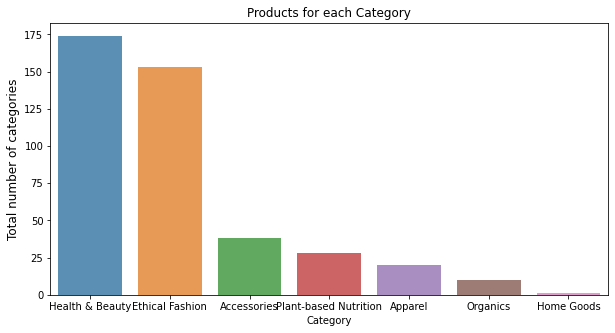

In [35]:
category_count = product.category.value_counts()
plt.figure(figsize=(10,5))
ax=sns.barplot(category_count.index, category_count.values, alpha=0.8)
plt.title('Products for each Category')
plt.ylabel('Total number of categories', fontsize=12)
plt.xlabel('Category', fontsize=10)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0.98, 'Products for each Category')

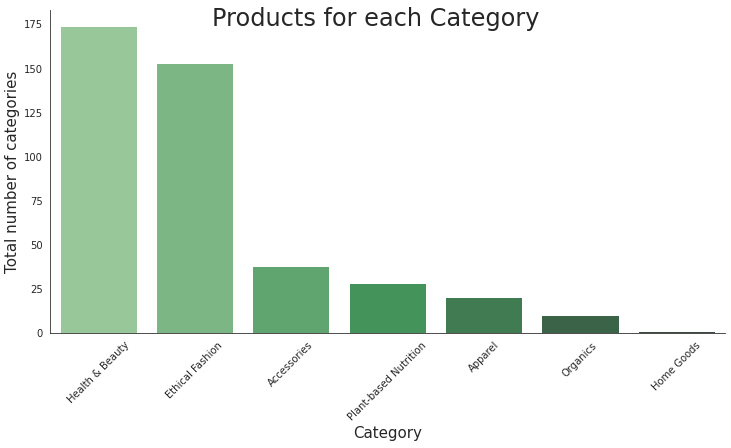

In [36]:
# Check the distribution of the category
        
with sns.axes_style('white'):
    g = sns.factorplot('category', data=product, aspect=2.0, palette="Greens_d",
                       kind='count',order=product.category.value_counts().index)
    g.set_ylabels('Total number of categories',fontsize=15)
    g.set_xlabels('Category',fontsize=15)
    g.fig.suptitle('Products for each Category',fontsize=24)
    g.set_xticklabels(rotation=45)
    # Set2

<AxesSubplot:xlabel='category'>

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Average_Price')

Text(0.5, 1.0, 'Average Price for each Category')

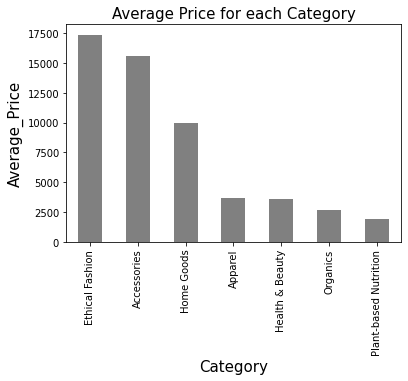

In [40]:
# Find average price for each category 
product['price_amount']=product['price_amount'].astype(float)
product['price_amount']=product['price_amount'].dropna()
price_category=product.groupby('category')['price_amount'].mean().sort_values(ascending=False)

# Plot average price for each category
price_category.plot(kind="bar", color='grey')
plt.xlabel('Category',fontsize=15)
plt.ylabel('Average_Price',fontsize=15)
plt.title('Average Price for each Category',fontsize=15)

### Payment Event

In [38]:
# payment.event_type.value_counts()

In [39]:
# # Create a dataset
# payment.event_type.value_counts(sort=True).plot(kind="bar")

# plt.xlabel('Event_type',fontsize=15)
# plt.ylabel('Number',fontsize=15)
# plt.title('Count event types',fontsize=15)

# 3. Recommender System 

## 3.1 Content Based Filtering

The content of the product is used to find its similarity with other product. Then the product that are most likely to be simliar are recommended. 

### 3.1.1 TFIDF
In this section, content based filtering will be implemented using description and characteristic of products. Ideally, some textual based columns should be content filtering through term frequency-inverse document frequency (TF-IDF).

In [40]:
# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

In [41]:
# Replace NaN with an empty string
product_tfidf['product_instruction']=product_tfidf['product_instruction'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(product_tfidf['product_instruction'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(528, 4347)

We see that nearly 8000 different words were used to describe the 418 items in product dataset. Now, it is time to compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. Calculating the dot product will give us the cosine similarity score because we employed the TF-IDF vectorizer. As a result, we'll utilise linear kernel() from sklearn instead of cosine similarities() because it's faster.

In [42]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [43]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(product_tfidf.index, index=product_tfidf['product_id']).drop_duplicates()

In [44]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(product_id, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[product_id]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:21]

    # Get the movie indices
    product_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return product_tfidf['product_id'].iloc[product_indices]

# Get recommended items 
get_recommendations('9bd7881d-0189-4e79-aefc-ab78bcbcbce9')

1     37c9ebce-9f8a-46f2-b13f-5fcb2fde0c5c
2     29605c38-e695-4752-8a65-8d1f831f9308
3     a4fb126d-8649-4131-8218-c164ee707dbe
4     362c5608-90ed-42a4-8008-7a37b623a859
5     e33d192f-51ae-40ce-b3dc-552cb084908c
6     e4c13d57-3ff6-48ae-8e76-e93eee14b350
7     7304d654-44b9-40e4-a584-188e7df7a5da
8     c3bb7ae7-00f9-4ce0-bab0-90435509f6c6
9     7079e002-fb36-4c84-a453-57bf61d804da
10    dd782612-097f-41ea-99f0-9b43aa7c88c6
11    601b3b0a-016d-4fde-9df0-adb6da35dd42
12    8ba5c269-f96c-4c6f-84fc-1cbb9a514c48
13    fdcd57b4-f4fe-4257-ab1b-06c26c202133
14    b0bc9f8c-fd87-4ed9-9c92-b84e200ebbbd
15    c6bb0265-7ab8-4894-87ae-e5d61bee3cd4
16    1f648abc-9f4e-4d0e-b55b-cf1b54258ece
17    cc035049-5392-4dd5-bfc5-5fe6c927bd5b
18    6339fa9a-7ef9-4586-90ba-e472a7de45a9
19    af022807-f88a-4109-b96a-0654257f967c
20    6081073d-57a7-4f53-b066-2bfbfebfa7d5
Name: product_id, dtype: object

Our technology did a good job of locating movies with comparable narrative descriptions, but the quality of the recommendations isn't excellent.

https://livebook.manning.com/book/practical-recommender-systems/chapter-10/56

### 3.1.2 Metadata Based Recommender 


The recommender would be increased with the usage of better metadata. Therefore, the recommender will be built based on the following metadata which have added into picky_bow_columns. 

The picky columns contians 'merchant_id', 'sku', 'name', 'product_instruction', 'category', 'brand', 'commodity_type', 'dimensions_weight', 'dimensions_weight_unit', 'name', 'price_amount', 'price_currency', 'price_discount_type', 'price_discount_amount', 'price_discount_vat', 'details', 'logo_id', 'default_file_id','size_map_file_id', 'preview', 'published_by', 'max_green_coins_percentage'. And then stored it in the form of "stringified" lists, which we must change into a secure and useable structure.

#### Cleaning Textual Data 

To prepare text data: 
- Drop description in non-English languages 
- Convert text to lower case 
- Delete punctuation, special characters 
- Remove stopwords 
- Lemmatization 

In [45]:
# Set product_id as index
product = product.set_index(keys='product_id')

In [46]:
# Convert all columns to strings
product = product.astype(str)

In order to create the content profile, some columns names are picked out considered as picky_bow_columns for further analysis. And employ a cosine meausre to calculate the similarity in the system. Based on the similarity, to selected out the top 20 products as recommendation products and save as product_picky_bow file.

In [47]:
# Select columns for picky bag of words 
picky_bow_columns = ['merchant_id', 'sku', 'name', 'product_instruction', 'category', 'brand',
                     'commodity_type', 'dimensions_weight', 'dimensions_weight_unit',
                     'name', 'price_amount', 'price_currency', 'price_discount_type',
                     'price_discount_amount', 'price_discount_vat', 'details', 
                     'logo_id', 'default_file_id','size_map_file_id', 'preview',
                     'published_by', 'max_green_coins_percentage']

Firstly, pulling the text apart and put it into a bag as the description of products. Then applying bag-of-words (BoW) model to split the description into an array of words.

In [48]:
# Collapse bag of columns 
product['bag_of_words'] = ''
columns = picky_bow_columns
for index, row in product.iterrows():
    words = ''
    for col in columns:
        words = words + row[col] + ' '
        row['bag_of_words'] = words
        
# Drop the columns outside the picky_bow_columns
product.drop(columns=[col for col in product.columns if col != 'bag_of_words'], inplace=True)

In [49]:
# Copy product 
product1=product.copy()
product1.columns=['bag_of_words_1']

# Convert index into column 
product1.reset_index(level=['product_id'], inplace=True)

In [50]:
# Remove stopwords
def remove_all_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text=[word for word in text if word not in stopword]
    return text

# Decontracted
def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Remove the numbers and punctuations that decect() does not accept
def remove_num_punc(text):
    c_pun = list(ch_pun)
    normal_pun = list(string.punctuation)
    punc = c_pun + normal_pun
    punc = punc + [':','(',"'"]
    num=[0,1,2,3,4,5,6,7,8,9]
    num=[str(x) for x in num]
    num_punc = num+punc
    return ''.join([words for words in text if words not in num_punc])

In [51]:
# Remove stopwords
def remove_most_stopwords(text):
    keep = ['no','not']
    stopword = [e for e in nltk.corpus.stopwords.words('english') if e not in keep]
    text=[word for word in text if word not in stopword]
    return text

# lemmatization
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

In [52]:
# Drop comments with sole punctuations and numbers so that the sentences can be recognised by detect() function
product.drop((product['bag_of_words'][product['bag_of_words'].apply(remove_num_punc)=='']).index,inplace=True)

# drop rows that are not in English
product.drop(product['bag_of_words'][product['bag_of_words'].apply(remove_num_punc).apply(detect)!='en'].index, inplace=True)

# Decontracted words such as 'isn't', 'shouldn't' to 'is not', 'should not'
product['bag_of_words']=product['bag_of_words'].apply(decontracted)

# Drop comments with sole punctuations and numbers so that the sentences can be recognised by detect() function
product.drop((product['bag_of_words'][product['bag_of_words'].apply(remove_num_punc)=='']).index,inplace=True)

# Remove \n from list of values within description 
product['bag_of_words']=product['bag_of_words'].replace(r'\n', ' ',regex=True)

# # The sentiment analysis keeps 'no', 'not', and used to apply in TFIDF

# product['tokens'] = product['bag_of_words'].apply(lambda t: remove_most_stopwords(nltk.word_tokenize(t.lower())))
# product['tokens']= [lemmatize_sentence(t) for t in product['tokens']]

product.to_csv('product_modified.csv', index=False)

In [53]:
# Import data 
product = pd.read_csv('product_modified.csv')

In [54]:
# Combine two columns 
product = pd.concat([product1, product], axis=1)

# Drop necessary columns 
product.dropna(inplace=True)
product.drop(['bag_of_words_1'], axis = 1, inplace=True)

# Set product_id as index
product = product.set_index(keys='product_id')

<Figure size 864x576 with 0 Axes>

(-0.5, 3999.5, 1999.5, -0.5)

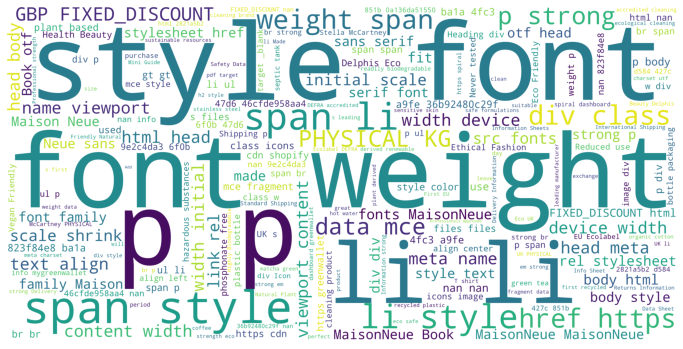

In [55]:
# Review keywords extraction
title_corpus = ' '.join(product['bag_of_words'])

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(12,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an product if it have been bought by many customers. It doesn't make much intuitive sense.

In [56]:
# Instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(product['bag_of_words'])

In [57]:
# counts = pd.DataFrame(count_matrix.toarray(),
#                       columns=count.get_feature_names())
# counts

In [58]:
# Generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

Now, it is time to reuse **recommend_CBF( )** function by passing in the new cosine_sim2 matrix as second argument.

In [59]:
# Creating a Series for the products ids so they are associated to an ordered numerical list I will use in the function
# to match the indexes

indices = pd.Series(product.index)

#  Defining the function that takes in product id as input and returns the top 10 products


def recommend_CBF(item, cosine_sim=cosine_sim):
    
    # Initializing the empty list of recommended products
    recommended_products = []
    
    # Getting the index of the product that matches the product id
    idx = indices[indices == item].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending=False)

    # Getting the indexes of the 20 most similar products
    top_20_indexes = list(score_series.iloc[1:21].index)
    
    # Populating the list with the titles of the best 20 matching products
    for i in top_20_indexes:
        recommended_products.append(list(product.index)[i])
        
    return recommended_products

# Test 20 best recommendations on a product id

recommend_CBF('9bd7881d-0189-4e79-aefc-ab78bcbcbce9')

# Add column of recommendations to product dataset

product.reset_index(level=0, inplace=True)
product['recommendations'] = product['product_id'].map(recommend_CBF)

# Write output csv for memory reasons

# product.to_csv('product_picky_bow.csv')

# This functions takes the list of recommendations indexes and changes it to a list of recommended product ids


def index_to_product_ids(product_indexes):
    return list([product['product_id'][i] for i in product_indexes])


def index_to_product_id(product_index):
    return product['product_id'][product_index]


# Apply the function to get a column with recommendations as product ids instead of indexes

product['recommended_product_ids'] = product['recommendations'].map(index_to_product_id)

# Write output csv for memory reasons

product.to_csv('product_picky_bow.csv')

# Drop unnecesary columns
# product = product.drop(columns=['bag_of_columns', 'recommendations'])

['5cf390f6-02c7-4a96-b72f-a6067be926e0',
 '5969917a-743e-4a8c-9311-ee15260186e5',
 'f312a2aa-fc9b-413f-8578-143461676189',
 '1aee16c9-2e73-48e0-88f9-62d8afff6e6f',
 '44803287-db00-4057-a788-c0f440bb3e6b',
 '2ede9d1e-7e48-424d-92e4-11c73dadebbc',
 'c1f86f1a-9dca-419a-b55c-5d893919d596',
 '41b3c7f7-3258-44b3-ae73-41777bfe484c',
 '652153f9-8144-4e57-b856-3ba2980f7d8e',
 '1452d111-c4fa-4815-8621-e3302b8892da',
 '2a36e815-5640-4ed7-a191-889ef94c4e65',
 'db508023-d545-4151-a12a-7035b43dcfad',
 '8ba5c269-f96c-4c6f-84fc-1cbb9a514c48',
 '35a5bbcb-a73c-4bf3-b795-b63d477e9898',
 '7f23cba8-1481-4017-9e3d-8cfb62622df9',
 '8364b948-a42c-401d-bc67-fde18c8b2ff1',
 'ff16bf5b-028f-4182-867b-61770c38d5e5',
 '0effc507-fab6-4bba-bd0e-72a6ae652fa0',
 '8b671ed4-6c1f-419f-a890-edbe2f17e5b6',
 '5fe6487d-9b44-49c0-9013-e7acb5850b25']

The recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. 

## 3.2 Data Simulation

In this section, keeping three columns ('user', 'item','rating') to begin our analysis. And then create demo purchase with 5 range ratings.

In [60]:
# Drop unnecesary columns including 'name'

payment = payment.drop(columns=['event_id', 'stream_id', 'version', 'event_type', 'mid', 'amount', 'version',
                                'currency', 'event_id', 'stream_id', 'card_token', 'event_time', 'event_type',
                                'merchant_id', 'redirect_url', 'transaction_id', 'billing_address_hash',
                                'shipping_address_hash', 'customer.phone', 'customer.reference', 'customer.email_hash',
                                'customer.phone_hash', 'customer.date_of_birth.day', 'customer.date_of_birth.year',
                                'customer.date_of_birth.month', 'billing_address.city', 'billing_address.name',
                                'billing_address.line1', 'billing_address.line2', 'billing_address.country',
                                'shipping_address.city', 'shipping_address.name', 'shipping_address.line1',
                                'shipping_address.line2', 'shipping_address.country', 'vat', 'shipping_method',
                                'customer.name', 'customer.last_name', 'customer.name_hash', 'customer.first_name',
                                'customer.last_name_hash', 'customer.first_name_hash', 'billing_address.last_name',
                                'billing_address.first_name', 'billing_address.postal_code', 'description',
                                'shipping_address.postal_code', 'shipping_address.last_name',
                                'shipping_address.first_name', 'auto_fulfill', 'shipping_amount',
                                'billing_address.line3', 'shipping_address.line3', 'customer.registration_date.day',
                                'customer.registration_date.year', 'customer.registration_date.month', 'green_coins',
                                'original_vat', 'original_amount', 'customer.customer_id',
                                'additional_data.application', 'billing_address.state', 'name', 'count', 'amount',
                                'currency', 'description', 'vat', 'variation_id', 'image_id', 'variants.SIZE',
                                'variants.OTHER', 'variants.COLOUR', 'variations', 'variants', 'date_processed'])

In [61]:
# Cleaning
payment = payment.dropna()

In [62]:
# Rename columns
payment.columns = ['user', 'item']

In [63]:
# Add random scores with same distribution as current reviews
np.random.seed(42)

population = [5, 4, 3, 1]
# population = [5, 3, 1]
weights = list(reviews.rating.value_counts(normalize=True))

payment['rating'] = choices(population, weights, k=len(payment))

In [64]:
payment.head()

,user,item,rating
48,checkout_demo@envisionworld.co,3773ea7b-223b-4342-862f-f7a8d842e333,4
62,checkout_demo@envisionworld.co,3773ea7b-223b-4342-862f-f7a8d842e333,4
70,zoeb@yopmail.com,1b8952a0-9d76-4c8b-93e9-c3fc6a5a7557,5
71,bashirkhairy@hotmail.com,cd4edb5d-7783-408a-8120-b4f78f3c64e8,5
86,bashirkhairy@hotmail.com,1b8952a0-9d76-4c8b-93e9-c3fc6a5a7557,4


In [65]:
# Simulate demo purchases

# Isolate user_id and product_id

user_id = users["customer_id"]
product_id = product["product_id"]

# Enlarge user_id to lcm 

c = np.repeat(user_id.values, len(product_id), axis=0)

user_id_large = pd.DataFrame(np.vstack(c))
print(user_id_large)

# Enlarge product_id to lcm

c = np.repeat(product_id.values, len(user_id), axis=0)

product_id_large = pd.DataFrame(np.vstack(c))
print(product_id_large)

# Randomly sort product_id large

product_id_large = product_id_large.sample(frac = 1).reset_index(drop = True)
print(product_id_large)

# Assemble simulated purchases dataframe

sim_purchases = pd.concat([user_id_large, product_id_large], axis=1)
sim_purchases.columns = ['user_id', 'product_id']

# Delete random rows 

np.random.seed(10)

remove_n = round(len(sim_purchases) * 0.7)
drop_indices = np.random.choice(sim_purchases.index, remove_n, replace = False)
sim_purchases = sim_purchases.drop(drop_indices).reset_index(drop = True)

# Create random scores

sim_purchases['score'] = np.random.randint(1, 6, sim_purchases.shape[0])
sim_purchases

                                           0
0       ab3252ee-0cfe-46be-add7-1e46982dbdaa
1       ab3252ee-0cfe-46be-add7-1e46982dbdaa
2       ab3252ee-0cfe-46be-add7-1e46982dbdaa
3       ab3252ee-0cfe-46be-add7-1e46982dbdaa
4       ab3252ee-0cfe-46be-add7-1e46982dbdaa
...                                      ...
189895  7634254c-2939-4a57-a81e-d1ce27574212
189896  7634254c-2939-4a57-a81e-d1ce27574212
189897  7634254c-2939-4a57-a81e-d1ce27574212
189898  7634254c-2939-4a57-a81e-d1ce27574212
189899  7634254c-2939-4a57-a81e-d1ce27574212

[189900 rows x 1 columns]
                                           0
0       9abf4537-3d98-4f57-9aa4-aa65c26169a8
1       9abf4537-3d98-4f57-9aa4-aa65c26169a8
2       9abf4537-3d98-4f57-9aa4-aa65c26169a8
3       9abf4537-3d98-4f57-9aa4-aa65c26169a8
4       9abf4537-3d98-4f57-9aa4-aa65c26169a8
...                                      ...
189895  cb3fd2c8-6533-4425-944b-46e4330a333d
189896  cb3fd2c8-6533-4425-944b-46e4330a333d
189897  cb3fd2c8-6533-4425-9

,user_id,product_id,score
0,ab3252ee-0cfe-46be-add7-1e46982dbdaa,c7d9eae4-6b59-439c-b658-4466f16bc8cb,4
1,ab3252ee-0cfe-46be-add7-1e46982dbdaa,6df9172d-5dbe-4ddf-a57e-cf6ed4194b6c,3
2,ab3252ee-0cfe-46be-add7-1e46982dbdaa,47386d3c-f563-4305-be7b-129ff76d5894,2
3,ab3252ee-0cfe-46be-add7-1e46982dbdaa,3f4d4c58-9e73-4d75-9b55-353a6c813944,5
4,ab3252ee-0cfe-46be-add7-1e46982dbdaa,2d1f4c37-c157-4b0e-b5e9-306984e5bd58,5
...,...,...,...
56965,7634254c-2939-4a57-a81e-d1ce27574212,35433af2-d4eb-4874-a693-b77f9e54072a,5
56966,7634254c-2939-4a57-a81e-d1ce27574212,c88d664e-ad1b-4071-b5cf-d7262946762d,3
56967,7634254c-2939-4a57-a81e-d1ce27574212,e489973b-dd45-409b-80d9-abdc47bcbeec,3
56968,7634254c-2939-4a57-a81e-d1ce27574212,709034da-1bf0-49e2-af29-31020f68c938,3


In [66]:
# Summary of numerical attributes
display(sim_purchases[['score']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
score,56970.0,2.992979,1.40911,1.0,2.0,3.0,4.0,5.0


Observations

Score : This is can be considered as categorical attribute with values of (1,2,3,4,5). The mean score is 2.5 which means most of the users have given very good ratings for the products i.e. half records with scores above 3. This can be seen from the median (Q2), 75% (Q3) and max values as 3. Even 25% (Q1) value is 2.0.

In [67]:
# Count unique users and products
print('Total unique users in the dataset', sim_purchases['user_id'].nunique())
print('Total unique products in the dataset', sim_purchases['product_id'].nunique())

Total unique users in the dataset 450
Total unique products in the dataset 422


### 3.2.1 Rating Distribution 

In [68]:
# Plot distribution of product scores (ratings) 
init_notebook_mode(connected=True)

data = sim_purchases['score'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / sim_purchases.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker_color='#7FFFD4'
               )
# Create layout
layout = dict(title = 'Distribution of {} product-scores'.format(sim_purchases.shape[0]),
              xaxis = dict(title = 'Score'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



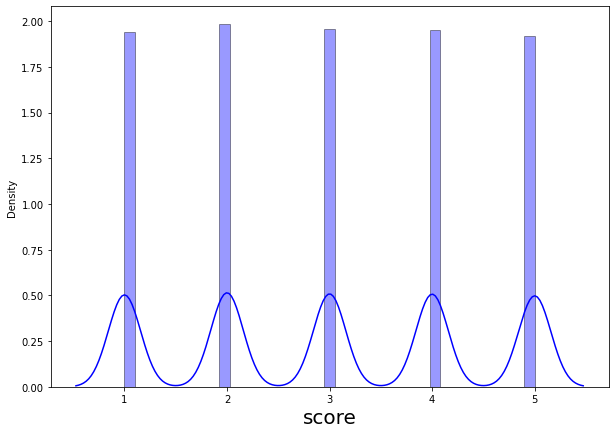

In [69]:
# Density of the score 
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

pal = sns.color_palette(palette='Set1', n_colors=16)

distplot(1, 1, 10, 7, data=sim_purchases, features=['score'], colors=['blue'])

Observations

The scores are nearly uniform distributed around 1 to 5. Rating 3 count for 20.2% which has highest number. While, ratings 1, 4 are comparatively less.

#### Accumulated score (product & user)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



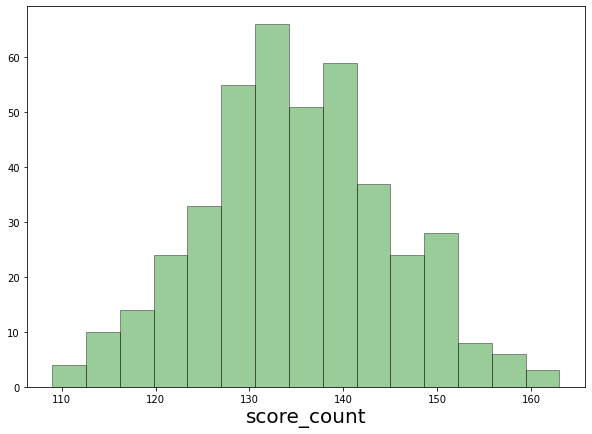

In [70]:
# Score count distribution grouped by products 
groupby_products_scores = sim_purchases.groupby('product_id')['score']
scores_products = pd.DataFrame(groupby_products_scores.count().clip())
scores_products.rename(columns={"score": "score_count"}, inplace=True)
distplot(1, 1, 10, 7, data=scores_products, features=['score_count'], colors=['green'], kde=False)

This shows score count distribution grouped by all the products. From the plot perspective, it close to normal distribution.

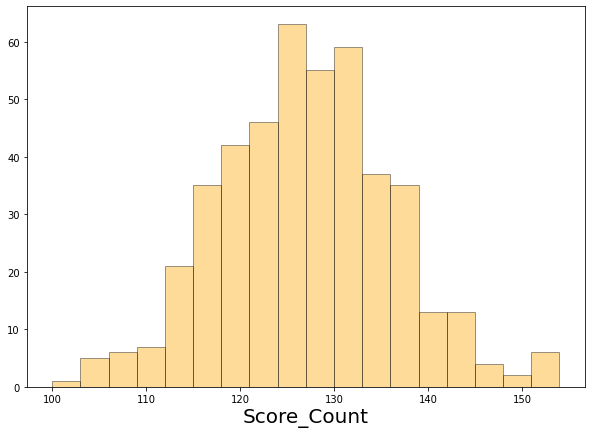

In [71]:
# Score count distribution grouped by users
groupby_user_scores = sim_purchases.groupby('user_id')['score']
scores_user = pd.DataFrame(groupby_user_scores.count().clip())
scores_user.rename(columns={"score": "Score_Count"}, inplace=True)
distplot(1, 1, 10, 7, data=scores_user, features=['Score_Count'], colors=['orange'], kde=False)

From the plot, the ratings count by users mainly centralized between 150 to 170.

#### Mean score (product & user)

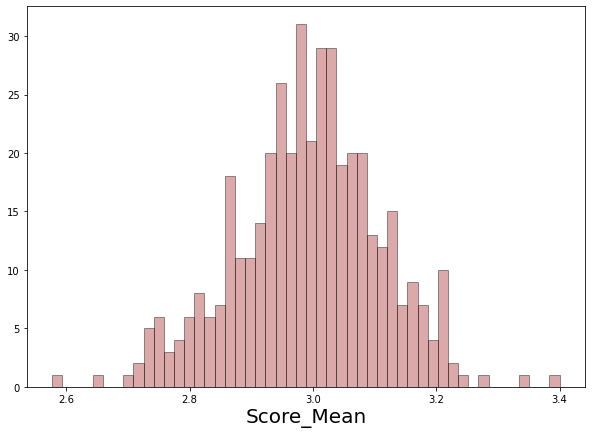

In [72]:
# Mean score distribution grouped by products 
scores = pd.DataFrame(sim_purchases.groupby('product_id')['score'].mean())
scores.rename(columns={"score": "Score_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=scores, features=['Score_Mean'], colors=['brown'], kde=False, bins=50)

Observations

This is a mean score distribution grouped by all the Products. As it can been seen from the plot, there are many products which were given a score around left of 3. Hence the plot shows lot of bins between 2.9 to 3.1.

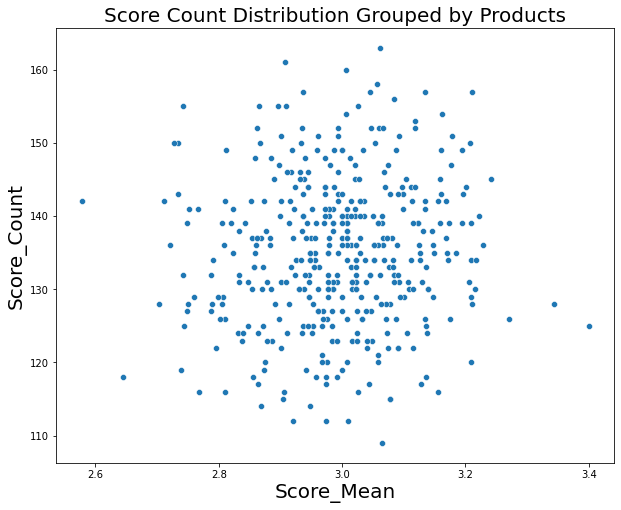

In [73]:
# Mean score - score count distribution grouped by products
scores['Score_Count'] = sim_purchases.groupby('product_id')['score'].count()
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20) 
    plot.set_title('Score Count Distribution Grouped by Products',fontsize=20) 
scatterplot('Score_Mean', 'Score_Count', data=scores)

Observations

This is a joint plot between Mean score distribution and Score Count grouped by all the Products. As shown in the plot, data is clustered around 3.

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



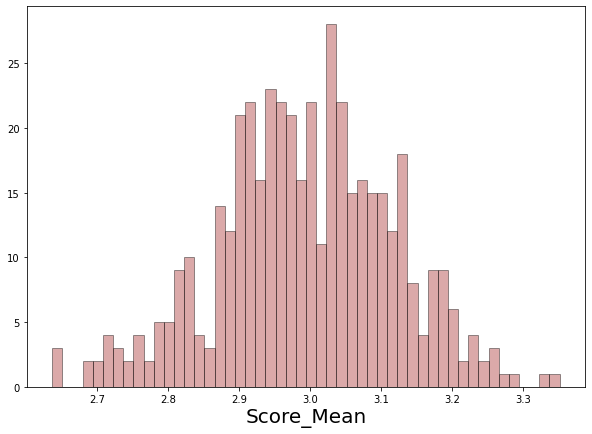

In [74]:
# Mean score distribution grouped by users
scores = pd.DataFrame(sim_purchases.groupby('user_id')['score'].mean())
scores.rename(columns={"score": "Score_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=scores, features=['Score_Mean'], colors=['brown'], kde=False, bins=50)

Observations

This is a mean rating distribution grouped by all the Users. Data is uniformly distribution from score left close to 3 with many around right of 3. Many users have an average score of around 3.

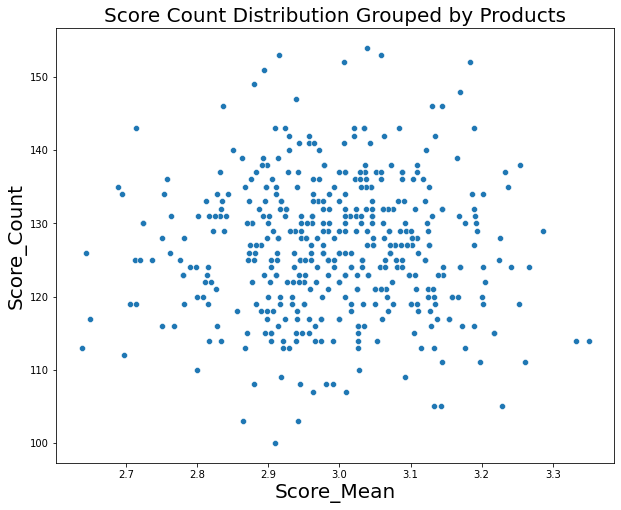

In [75]:
# Mean score - score count distirbution grouped by users 
scores['Score_Count'] = sim_purchases.groupby('user_id')['score'].count()
scatterplot('Score_Mean', 'Score_Count', data=scores)

The distribution more disperse, but there is no much change as a whole.

In [76]:
sim_purchases.head()

,user_id,product_id,score
0,ab3252ee-0cfe-46be-add7-1e46982dbdaa,c7d9eae4-6b59-439c-b658-4466f16bc8cb,4
1,ab3252ee-0cfe-46be-add7-1e46982dbdaa,6df9172d-5dbe-4ddf-a57e-cf6ed4194b6c,3
2,ab3252ee-0cfe-46be-add7-1e46982dbdaa,47386d3c-f563-4305-be7b-129ff76d5894,2
3,ab3252ee-0cfe-46be-add7-1e46982dbdaa,3f4d4c58-9e73-4d75-9b55-353a6c813944,5
4,ab3252ee-0cfe-46be-add7-1e46982dbdaa,2d1f4c37-c157-4b0e-b5e9-306984e5bd58,5


## 3.3 Collaborative Filtering



Model-based algorithms, in contrast to memory-based algorithms, attempt to model users based on their past ratings and use these models to anticipate ratings on unseen things. The model calculate the similarities between users/items based on user-item rating pairs. However, the original database only 36 products having ratings, so more random scores will be added in with same distribution as current ratings.  

Then, there are some different types of models will be applied:

> NormalPredictor: forecasts a random rating using the training set's distribution, which is considered to be normal. One of the most basic algorithms that doesn't require a lot of effort.

> K-NN algorithms (menmory based)
- KNNBasic: basic CF algorithm 
- KNNWithMeans: basic CF takes into account each user's average rating.
- KNNWithZScore: basic CF takes into account z-score normalization of each user
- KNNBaseline: basic CF takes into account baseline rating

> Matrix Factorization-based algorithms (model-based)
- SVD: equivalent to Probabilistic Matrix Factorization.
- SVDpp: taking into account implicit ratings. 
- NMF: non-negative Matrix Factorization, which similar to SVD.
- SlopeOne: a straightforward implementation of SlopeOne algorithm. 
- CoClustering: a CF algorithm based on co-clustering. 


For each of the model, cross_validate method will be used to find the one with the highest mean absolute error (MAE) or root mean squared error (RMSE). And the result will be saved as .csv files. Furthermore, using gridsearchcv method to do some hyperparameter optimization. 

### 3.3.1 Cleaning Data


In [77]:
# # Drop unnecesary columns 

# payment = payment.drop(columns = ['event_id', 'stream_id', 'version', 'event_type',
#                                  'mid', 'amount', 'version', 'currency', 'event_id', 'stream_id',
#                                  'card_token', 'event_time', 'event_type', 'merchant_id',
#                                  'redirect_url','transaction_id', 'billing_address_hash',
#                                  'shipping_address_hash', 'customer.phone', 'customer.reference',
#                                  'customer.email_hash', 'customer.phone_hash',
#                                  'customer.date_of_birth.day', 'customer.date_of_birth.year',
#                                  'customer.date_of_birth.month', 'billing_address.city',
#                                  'billing_address.name', 'billing_address.line1',
#                                  'billing_address.line2', 'billing_address.country',
#                                  'shipping_address.city', 'shipping_address.name',
#                                  'shipping_address.line1', 'shipping_address.line2',
#                                  'shipping_address.country', 'vat', 'shipping_method', 'customer.name',
#                                  'customer.last_name', 'customer.name_hash', 'customer.first_name',
#                                  'customer.last_name_hash', 'customer.first_name_hash',
#                                  'billing_address.last_name', 'billing_address.first_name',
#                                  'billing_address.postal_code', 'description',
#                                  'shipping_address.postal_code', 'shipping_address.last_name',
#                                  'shipping_address.first_name', 'auto_fulfill', 'shipping_amount',
#                                  'billing_address.line3', 'shipping_address.line3',
#                                  'customer.registration_date.day', 'customer.registration_date.year',
#                                  'customer.registration_date.month', 'green_coins', 'original_vat',
#                                  'original_amount', 'customer.customer_id', 'additional_data.application',
#                                  'billing_address.state', 'count', 'amount', 'currency',
#                                  'description', 'vat', 'variation_id', 'image_id', 'variants.SIZE',
#                                  'variants.OTHER', 'variants.COLOUR', 'variations', 'variants',
#                                  'date_processed'])

In [78]:
# Drop columns

# payment = payment.drop(columns = ['event_id', 'stream_id', 'version', 'event_type', 'date_processed',
#                                  'mid', 'amount', 'version', 'currency', 'event_id', 'stream_id',
#                                  'card_token', 'event_time', 'event_type', 'merchant_id',
#                                  'redirect_url', 'transaction_id', 'count', 'amount', 'currency', 
#                                  'description'])

**Surprise**

Using the load from df() method to load a data set from the aforementioned pandas data frame; we'll also need a Reader object and the rating scale option must be given. The data frame must contain three columns, which correspond to the user_id, item_id, and ratings (scores) in that order. As a result, each row correlates to a certain rating.

In [79]:
# Set dataframe for Surprise models
reader = Reader(line_format='user item rating', sep=';', rating_scale=(1, 5), skip_lines=1)
data = Dataset.load_from_df(payment, reader=reader)

### 3.3.2 Data Preparation

The first approach is split data into trainset and testset in the ratio of 70:30 respectively. Another approach is to use full data and cross-validate for testing.

In [80]:
# Splitting the data into trainset and testset with 30% size
trainset, testset = train_test_split(data, test_size=0.3)

# Getting the number of items/users
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

# Convert between items and integers
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

# Using full data to save distance metrics
trainsetfull = data.build_full_trainset()
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

Number of users:  166 

Number of items:  193 

Number of users:  207 

Number of items:  229 



### 3.3.3 Model Parameters

The hyperparameters tuning mainly focus on k parameter and similarity option.

In [81]:
# Three similarity metrics 
sim_msd = {'name':'MSD', 'user_based':False}
sim_cos = {'name':'cosine', 'user_based':False}
sim_pearson = {'name':'pearson', 'user_based':False}
sim_pearson_baseline = {'name': 'pearson_baseline','user_based':False, 'shrinkage': 100}

sim_options = [sim_msd, sim_cos, sim_pearson, sim_pearson_baseline]

# Set K parameter 
list_of_ks = [10,20,30]

### 3.3.4 Models Comparation

A similar process with no baseline model and use corss-validate to calculate scores of different models, then pick the best one. Finally fit it on the trainset and test on the testset. 

In [82]:
# Compare algorithms performance

benchmark = []
algorithms = [SVD(),
              SVDpp(),
              SlopeOne(),
              NMF(),
              NormalPredictor(),
              KNNBaseline(),
              KNNBasic(),
              KNNWithMeans(),
              KNNWithZScore(),
              BaselineOnly(),
              CoClustering()]

# Iterate over all algorithms
for algorithm in algorithms:

    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
analysis_df=pd.DataFrame(benchmark).sort_values('test_rmse')
analysis_df
#.set_index('Algorithm')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,test_mae,fit_time,test_time,Algorithm
1,0.869166,0.675798,3.295211,0.101931,SVDpp
9,0.870176,0.685138,0.001437,0.002349,BaselineOnly
0,0.878109,0.685144,0.070838,0.004522,SVD
6,0.903994,0.695684,0.002399,0.033677,KNNBasic
7,0.907758,0.690532,0.004656,0.036584,KNNWithMeans
8,0.910554,0.701203,0.007624,0.040342,KNNWithZScore
5,0.920623,0.703122,0.003147,0.042121,KNNBaseline
2,0.922765,0.702465,0.009593,0.060520,SlopeOne
10,0.926683,0.712206,0.036116,0.002697,CoClustering
3,0.955481,0.747997,0.078185,0.003277,NMF


In [83]:
analysis_df1=pd.DataFrame(benchmark).sort_values('test_time')
analysis_df1

,test_rmse,test_mae,fit_time,test_time,Algorithm
9,0.870176,0.685138,0.001437,0.002349,BaselineOnly
10,0.926683,0.712206,0.036116,0.002697,CoClustering
3,0.955481,0.747997,0.078185,0.003277,NMF
4,1.128389,0.850579,0.001144,0.003616,NormalPredictor
0,0.878109,0.685144,0.070838,0.004522,SVD
6,0.903994,0.695684,0.002399,0.033677,KNNBasic
7,0.907758,0.690532,0.004656,0.036584,KNNWithMeans
8,0.910554,0.701203,0.007624,0.040342,KNNWithZScore
5,0.920623,0.703122,0.003147,0.042121,KNNBaseline
2,0.922765,0.702465,0.009593,0.060520,SlopeOne


[Text(0.5, 1.0, 'RMSE For Algorithms')]

[Text(0, 0, 'BaselineOnly'),
 Text(1, 0, 'CoClustering'),
 Text(2, 0, 'NMF'),
 Text(3, 0, 'NormalPredictor'),
 Text(4, 0, 'SVD'),
 Text(5, 0, 'KNNBasic'),
 Text(6, 0, 'KNNWithMeans'),
 Text(7, 0, 'KNNWithZScore'),
 Text(8, 0, 'KNNBaseline'),
 Text(9, 0, 'SlopeOne'),
 Text(10, 0, 'SVDpp')]

Text(0.0, 0.0014366308848063152, '0.00')

Text(1.0, 0.03611596425374349, '0.04')

Text(2.0, 0.07818484306335449, '0.08')

Text(3.0, 0.0011443297068277996, '0.00')

Text(4.0, 0.07083821296691895, '0.07')

Text(5.0, 0.0023993651072184243, '0.00')

Text(6.0, 0.004656314849853516, '0.00')

Text(7.0, 0.007624228795369466, '0.01')

Text(8.0, 0.0031474431355794272, '0.00')

Text(9.0, 0.009593009948730469, '0.01')

Text(10.0, 3.295210679372152, '3.30')

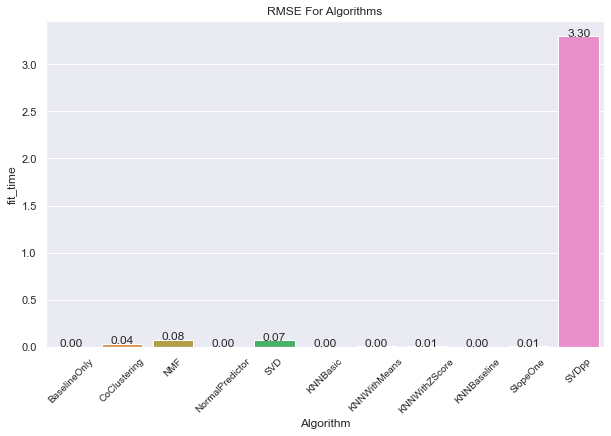

In [84]:
# plot vertical barplot
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x='Algorithm', y='test_time', data=analysis_df1)
ax.set(title='Test_time For Algorithms') # title barplot
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, size = 10)
# label each bar in barplot
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
         s = '{:.2f}'.format(height), y = height, ha = 'center')

[Text(0.5, 1.0, 'RMSE For Algorithms')]

[Text(0, 0, 'SVDpp'),
 Text(1, 0, 'BaselineOnly'),
 Text(2, 0, 'SVD'),
 Text(3, 0, 'KNNBasic'),
 Text(4, 0, 'KNNWithMeans'),
 Text(5, 0, 'KNNWithZScore'),
 Text(6, 0, 'KNNBaseline'),
 Text(7, 0, 'SlopeOne'),
 Text(8, 0, 'CoClustering'),
 Text(9, 0, 'NMF'),
 Text(10, 0, 'NormalPredictor')]

Text(0.0, 0.869165688524652, '0.87')

Text(1.0, 0.8701761102607174, '0.87')

Text(2.0, 0.8781087602356848, '0.88')

Text(3.0, 0.9039937921028507, '0.90')

Text(4.0, 0.907757903978245, '0.91')

Text(5.0, 0.9105535456258753, '0.91')

Text(6.0, 0.9206227806314543, '0.92')

Text(7.0, 0.9227653439752167, '0.92')

Text(8.0, 0.9266834247977744, '0.93')

Text(9.0, 0.9554805413080801, '0.96')

Text(10.0, 1.1283888580321744, '1.13')

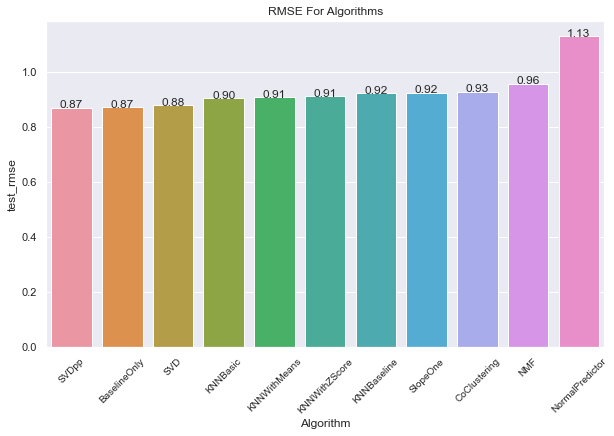

In [85]:
# plot vertical barplot
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x='Algorithm', y='test_rmse', data=analysis_df)
ax.set(title='RMSE For Algorithms') # title barplot
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, size = 10)
# label each bar in barplot
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
         s = '{:.2f}'.format(height), y = height, ha = 'center')

Looking at the above result, we can say BaselineOnly model works well with the data as it is having the least RMSE score of 0.89. Based on the table, we can find the best perfomance top three are BaselineOnly, SVDpp and SVD performs followed. But, SVDpp takes lots of time. Next, applying GridSearch CV. 

**Train and Predict**

BaselineOnly algorithm gave us the best rmse, therefore, we will train and predict with BaselineOnly and use Alternating Least Squares (ALS) and Stochastic Gradient Descent (SGD).

In [86]:
print('Using ALS')
bsl_options={'method':'als',
            'n_epochs':10,
            'reg_u':12,
            'reg_i':5
            }
algo=BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Use the fit() method which will train the algorithm on the trainset, 
# and the test() method which will return the predictions made from the testset.
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.90909935, 0.79458551, 0.90782659]),
 'test_mae': array([0.69501304, 0.64771168, 0.70968993]),
 'fit_time': (0.0015010833740234375,
  0.0015192031860351562,
  0.0013730525970458984),
 'test_time': (0.002538919448852539,
  0.002496004104614258,
  0.0029168128967285156)}

Estimating biases using als...
RMSE: 0.8418


0.8417773509619266

In [87]:
param_grid = {'bsl_options':{'method': ['als','sgd'],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}}
bsl_algo = BaselineOnly()
gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=3)

In [88]:
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [89]:
print('Using SGD')
bsl_options={'method':'sgd',
            'n_epochs':5,
            'lr_all': 0.002,
            'reg_all': 0.4
            }
algo=BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Use the fit() method which will train the algorithm on the trainset, 
# and the test() method which will return the predictions made from the testset.
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Using SGD
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


{'test_rmse': array([0.86777548, 0.91638668, 0.80468675]),
 'test_mae': array([0.68191227, 0.71377216, 0.65358645]),
 'fit_time': (0.001271963119506836,
  0.0015130043029785156,
  0.0012149810791015625),
 'test_time': (0.0024390220642089844,
  0.002499103546142578,
  0.0024099349975585938)}

Estimating biases using sgd...
RMSE: 0.8316


0.8315986905661794

### 3.3.5 Hyperparameter Tuning

#### 3.3.5.1 Matrix Factorization 

**SVD**

GridSearch model can help to tune SVD model, and the paramters inludes: number of factors, number of epochs, learning rate and the regularizatin.

In [91]:
# Grid for testing 
param_grid = {
    "n_factors":[5, 10, 20, 30, 40, 50],
    "n_epochs": [5, 10, 15, 20, 30, 40, 50, 100],
    "lr_all": [0.001, 0.002, 0.005, 0.06],
    "reg_all": [0.02, 0.08, 0.4, 0.6, 0.7]
}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.8620288431608278
BEST MAE: 	 0.6809283406912338
BEST params: 	 {'n_factors': 50, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.7}


The result of RMSE for the model is 0.869 and the best parameters are n_factors=50, n_epochs=5, lr_all=0.001, reg_all=0.7.

In [92]:
# Choose model fitting
chosen_SVD = SVD(n_epochs=10, lr_all=0.001, reg_all=0.6)
chosen_SVD.fit(trainset)
predictions = chosen_SVD.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8292


0.8291927197665171

**SVDpp**

In [93]:
param_grid_SVDpp = {'n_factors':[20, 30],'n_epochs': [20], 'lr_all': [0.006, 0.01],
              'reg_all': [0.7, 1]}

gs_model_SVDpp = GridSearchCV(SVDpp,param_grid=param_grid_SVDpp, n_jobs = -1, joblib_verbose=5)
gs_model_SVDpp.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   54.3s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   56.2s finished


In [94]:
training_parameters = gs_model_SVDpp.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.8620288431608278
BEST MAE: 	 0.6809283406912338
BEST params: 	 {'n_factors': 50, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.7}


In [95]:
# Chose model fitting
chosen_SVD = SVD(n_epochs=10, lr_all=0.001, reg_all=0.6)
chosen_SVD.fit(trainset)
predictions = chosen_SVD.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8283


0.8282940745551356

**CoClustering**

In [96]:
algo = CoClustering(n_cltr_u = 3, n_cltr_i = 3)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

<ipython-input-96-a1115f10f4c7>:2: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



RMSE: 0.9348


0.9347843521863459

In [97]:
algo = CoClustering(n_cltr_u = 5, n_cltr_i = 5)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

<ipython-input-97-f573bf3e71dc>:2: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



RMSE: 0.9441


0.9441196711064727

**KNN without baseline**

In [98]:
# create a file for saving KNN_socres

with open('kNN_scores.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['model_type', 'similarity_option', 'k', 'train_rmse', 'test_rmse',
                     'train_mae', 'test_mae'
                    ])

72

In [99]:
# Compare different modules' performance 

algorithms = [KNNBasic(),
              KNNWithMeans(),
              KNNWithZScore(),             
             ]

for algorithm in algorithms:  
    for curr_sim_option in sim_options[0:3]:
        for curr_k in list_of_ks:
            print(
            'Currently calculating sim_option = ' + str(curr_sim_option['name']) + \
            ' and k = ' + str(curr_k) + ' ...' )  
            results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, return_train_measures=True);
            with open('kNN_scores.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow(
                    [str(algorithm).split(' ')[0].split('.')[-1], curr_sim_option['name'], str(curr_k),
                     str(np.mean(results['train_rmse'])), str(np.mean(results['test_rmse'])),
                    str(np.mean(results['train_mae'])), str(np.mean(results['test_mae']))])            

Currently calculating sim_option = MSD and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


93

Currently calculating sim_option = MSD and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


93

Currently calculating sim_option = MSD and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


92

Currently calculating sim_option = cosine and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


95

Currently calculating sim_option = cosine and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


95

Currently calculating sim_option = cosine and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


96

Currently calculating sim_option = pearson and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


97

Currently calculating sim_option = pearson and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


96

Currently calculating sim_option = pearson and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


95

Currently calculating sim_option = MSD and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


97

Currently calculating sim_option = MSD and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


96

Currently calculating sim_option = MSD and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


96

Currently calculating sim_option = cosine and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


98

Currently calculating sim_option = cosine and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


100

Currently calculating sim_option = cosine and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


100

Currently calculating sim_option = pearson and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


101

Currently calculating sim_option = pearson and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


100

Currently calculating sim_option = pearson and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


101

Currently calculating sim_option = MSD and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


98

Currently calculating sim_option = MSD and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


98

Currently calculating sim_option = MSD and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


97

Currently calculating sim_option = cosine and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


101

Currently calculating sim_option = cosine and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


100

Currently calculating sim_option = cosine and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


101

Currently calculating sim_option = pearson and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


101

Currently calculating sim_option = pearson and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


102

Currently calculating sim_option = pearson and k = 30 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


101

In [100]:
# Looking for smallest test_rmse
df = pd.read_csv('kNN_scores.csv')
df = df.sort_values(['test_rmse'])
df

,model_type,similarity_option,k,train_rmse,test_rmse,train_mae,test_mae
8,KNNBasic,pearson,30,0.753539,0.898221,0.558125,0.689261
2,KNNBasic,MSD,30,0.752674,0.902238,0.553964,0.696093
18,KNNWithZScore,MSD,10,0.734679,0.902682,0.526533,0.687972
14,KNNWithMeans,cosine,30,0.735208,0.904247,0.523383,0.693516
4,KNNBasic,cosine,20,0.752210,0.906021,0.554353,0.696801
0,KNNBasic,MSD,10,0.752071,0.906530,0.553190,0.700552
24,KNNWithZScore,pearson,10,0.736018,0.909301,0.523206,0.698386
15,KNNWithMeans,pearson,10,0.733924,0.910128,0.523164,0.694931
17,KNNWithMeans,pearson,30,0.735329,0.910180,0.522306,0.700631
19,KNNWithZScore,MSD,20,0.735339,0.910272,0.524945,0.700145


Based on the results, the best model is: 

- model type: KNNBasic
- similarity option: cosine
- k: 30 

### Chosen Model Fitting 

In [102]:
# Chosen model fitting 
chosen_k = 10
chosen_sim_option = sim_cos
chosen_knn = KNNBasic(k = chosen_k, sim_options = chosen_sim_option)
chosen_knn.fit(data.build_full_trainset())
predictions = chosen_knn.test(testset)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.


RMSE: 0.7859


0.7858694025358602

**rmse score for the chosen KNNBasic model is 0.8065**

### 3.3.5.3 KNN Models without Baseline

#### Hyperparameter Tuning-SGD

- focus on two potential things: reg and learning rate

In [103]:
sgd_bsl_options = [
    {'method':'sgd', 'reg': 0.02, 'learning_rate': 0.005},
    {'method':'sgd', 'reg': 0.05, 'learning_rate': 0.005},
    {'method':'sgd', 'reg': 0.1, 'learning_rate': 0.005},
    {'method':'sgd', 'reg': 0.02, 'learning_rate': 0.01},
    {'method':'sgd', 'reg': 0.05, 'learning_rate': 0.01},
    {'method':'sgd', 'reg': 0.1, 'learning_rate': 0.01}
]

In [104]:
with open('kNN_baseline_sgd_scores.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['reg', 'learning_rate', 'k', 'train_rmse', 'test_rmse'])

42

In [105]:
for curr_bsl_option in sgd_bsl_options:

    for curr_k in list_of_ks:
        
        print(
            'Currently calculating k = ' + str(curr_k) + ' ...'
        )        
        algo = KNNBaseline(k = curr_k, sim_options = sim_pearson_baseline, bsl_options = curr_bsl_option)
        results = cross_validate(algo, data, measures=['RMSE'], cv=3, return_train_measures=True);
        
        with open('kNN_baseline_sgd_scores.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(
                [curr_bsl_option['reg'], curr_bsl_option['learning_rate'],str(curr_k), 
                 str(np.mean(results['train_rmse'])), str(np.mean(results['test_rmse']))])

Currently calculating k = 10 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


53

Currently calculating k = 20 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


53

Currently calculating k = 30 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


53

Currently calculating k = 10 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


53

Currently calculating k = 20 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


53

Currently calculating k = 30 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


53

Currently calculating k = 10 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 20 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 30 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 10 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


51

Currently calculating k = 20 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 30 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 10 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 20 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 30 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


52

Currently calculating k = 10 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


51

Currently calculating k = 20 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


51

Currently calculating k = 30 ...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


51

In [106]:
df = pd.read_csv('kNN_baseline_sgd_scores.csv')
df.sort_values(by = 'test_rmse', inplace = True)
df

,reg,learning_rate,k,train_rmse,test_rmse
17,0.10,0.010,30,0.700553,0.919530
14,0.05,0.010,30,0.699550,0.926867
7,0.10,0.005,20,0.702772,0.927110
6,0.10,0.005,10,0.711001,0.928375
9,0.02,0.010,10,0.703002,0.929415
2,0.02,0.005,30,0.700340,0.930514
10,0.02,0.010,20,0.701516,0.932198
16,0.10,0.010,20,0.704807,0.932320
8,0.10,0.005,30,0.700259,0.934116
4,0.05,0.005,20,0.698408,0.938124


In [107]:
# Chose model fitting -SGD
chosen_reg_sgd = 0.02
chosen_learning_rate_sgd = 0.005
chosen_k_sgd = 20

chosen_knn_baseline_sgd = KNNBaseline(
    k = chosen_k_sgd, 
    sim_options = sim_pearson_baseline,
    bsl_options = {
        'method':'sgd', 'reg': chosen_reg_sgd,  'learning_rate': chosen_learning_rate_sgd}
    )
chosen_knn_baseline_sgd.fit(trainset)
predictions = chosen_knn_baseline_sgd.test(testset)
accuracy.rmse(predictions)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 0.9301


0.9301403957674345

rmse score for the chosen kNN with sgd baseline model is 0.882.

### 3.3.5.3 KNN Models with Baseline

#### Hyperparameter Tuning -ALS

With als, there are two things to potentially tune tune: reg_i and reg_u

In [108]:
als_bsl_options = [
    {'method':'als', 'reg_i': 20, 'reg_u': 30},
    {'method':'als', 'reg_i': 40, 'reg_u': 60},
    {'method':'als', 'reg_i': 20, 'reg_u': 30},
    {'method':'als', 'reg_i': 40, 'reg_u': 60}
]

with open('kNN_baseline_als_scores.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['reg_i', 'reg_u', 'k', 'train_rmse', 'test_rmse'])

36

In [109]:
for curr_als_option in als_bsl_options:

    for curr_k in list_of_ks:
        
        print(
            'Currently calculating k = ' + str(curr_k) + ' ...'
        )   
        algo = KNNBaseline(k = curr_k, sim_options = sim_pearson_baseline, als_options = curr_als_option)
        results = cross_validate(algo, data, measures=['RMSE'], cv=3, return_train_measures=True);
        
        with open('kNN_baseline_als_scores.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(
                [curr_als_option['reg_i'], curr_als_option['reg_u'],str(curr_k), 
                 str(np.mean(results['train_rmse'])), str(np.mean(results['test_rmse']))])

Currently calculating k = 10 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 20 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


47

Currently calculating k = 30 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 10 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


47

Currently calculating k = 20 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 30 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 10 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 20 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 30 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


47

Currently calculating k = 10 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

Currently calculating k = 20 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


47

Currently calculating k = 30 ...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


48

In [110]:
df = pd.read_csv('kNN_baseline_als_scores.csv')
df.sort_values(by = 'test_rmse', inplace = True)
df

,reg_i,reg_u,k,train_rmse,test_rmse
2,20,30,30,0.702499,0.908751
8,20,30,30,0.704519,0.912283
7,20,30,20,0.702574,0.916420
4,40,60,20,0.702089,0.922919
5,40,60,30,0.699724,0.925411
11,40,60,30,0.701962,0.926912
1,20,30,20,0.699106,0.933212
0,20,30,10,0.703780,0.934321
6,20,30,10,0.705486,0.935168
10,40,60,20,0.698339,0.935187


In the best performing model, reg_i = 20, reg_u = 30, k = 20.

In [111]:
# chose model fitting - ALS
chosen_reg_i_als = 20
chosen_reg_u_als = 30
chosen_k_als = 20

In [112]:
chosen_knn_baseline_als = KNNBaseline(
    k = chosen_k_als, 
    sim_options = sim_pearson_baseline,
    bsl_options = {
        'method':'als', 'reg_i':chosen_reg_i_als, 'reg_u': chosen_reg_u_als }
    )
chosen_knn_baseline_als.fit(trainset)
predictions = chosen_knn_baseline_als.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 0.9325


0.932473748290604

rmse score for the chosen kNN with als baseline model is 0.885.

### 3.3.5.4 KNN Models Results 
We picked one hyperparameter setup from three model groups, all of them kNN-type models:

- for the basic model with no baseline, rmse = 0.807
- for the baseline model with sgd, rmse = 0.882
- for the baseline model with als, rmse = 0.885

It is clear that the results are quite close to each other, but strictly speaking, the kNN basic model with no baseline method to estimate the baseline performed the best out of the three types.

## 3.3.6 Model Based Recommendation System 

### SVD

In [125]:
# SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results
SVD_cv=pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
SVD_cv

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8997  0.8567  0.9020  0.8948  0.8288  0.8764  0.0290  
MAE (testset)     0.6812  0.6803  0.6986  0.6957  0.6683  0.6848  0.0111  
Fit time          0.09    0.08    0.08    0.09    0.09    0.09    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


,test_rmse,test_mae,fit_time,test_time
0,0.899670,0.681231,0.089689,0.002359
1,0.856675,0.680273,0.083235,0.002302
2,0.902047,0.698596,0.084263,0.002533
3,0.894788,0.695678,0.090987,0.002988
4,0.828817,0.668331,0.087168,0.002250


In [114]:
# train SVD

algo = SVD()
output = algo.fit(data.build_full_trainset())

# provide recommendations with SVD

iids = sim_purchases['product_id'].unique()
iids50 = sim_purchases.loc[sim_purchases['user_id'] == 50, 'product_id']
iids_to_pred = np.setdiff1d(iids, iids50)

testset = [[50, iid, 4.] for iid in iids_to_pred]
predictions = algo.test(testset)
predictions [0:5]

[Prediction(uid=50, iid='00f6d668-aac8-4fe3-9564-1747f3fd06d6', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='02e3bf8f-57cd-4416-97e9-1fe5b4eef872', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='043c1adb-3547-48e1-abfd-94bd4b4ad60e', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='046c6fd4-fb76-40dd-8f80-7963ab983542', r_ui=4.0, est=4.153016341774171, details={'was_impossible': False}),
 Prediction(uid=50, iid='05ee6b58-d6f1-45a0-b291-21ac84d9fd96', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False})]

## SVDpp

In [128]:
# SVDpp algorithm 
algo1 = SVDpp()

# Run 5-fold cross-validation and print results
SVDpp_cv=pd.DataFrame(cross_validate(algo1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
SVDpp_cv

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9431  0.8944  0.7489  0.9165  0.9036  0.8813  0.0682  
MAE (testset)     0.7205  0.7068  0.6226  0.7042  0.6901  0.6888  0.0345  
Fit time          4.41    4.31    4.24    4.28    4.20    4.29    0.07    
Test time         0.07    0.07    0.07    0.07    0.06    0.07    0.00    


,test_rmse,test_mae,fit_time,test_time
0,0.943084,0.720450,4.410279,0.071260
1,0.894366,0.706784,4.307957,0.065932
2,0.748871,0.622580,4.240471,0.065621
3,0.916475,0.704151,4.276509,0.065880
4,0.903553,0.690134,4.200756,0.059979


In [116]:
# train SVDpp()
algo = SVDpp()
output = algo.fit(trainsetfull)

# provide recommendations with SVDpp

iids = sim_purchases['product_id'].unique()
iids50 = sim_purchases.loc[sim_purchases['user_id'] == 50, 'product_id']
iids_to_pred = np.setdiff1d(iids, iids50)

testset = [[50, iid, 4.] for iid in iids_to_pred]
predictions = algo.test(testset)
predictions [0:5]

[Prediction(uid=50, iid='00f6d668-aac8-4fe3-9564-1747f3fd06d6', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='02e3bf8f-57cd-4416-97e9-1fe5b4eef872', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='043c1adb-3547-48e1-abfd-94bd4b4ad60e', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='046c6fd4-fb76-40dd-8f80-7963ab983542', r_ui=4.0, est=4.078668905819661, details={'was_impossible': False}),
 Prediction(uid=50, iid='05ee6b58-d6f1-45a0-b291-21ac84d9fd96', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False})]

## NMF

In [129]:
# NMF
algo = NMF()

# Run 5-fold cross-validation and print results
NMF_cv=pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
NMF_cv

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9660  0.9186  0.9294  0.9506  1.0079  0.9545  0.0314  
MAE (testset)     0.7551  0.6939  0.7065  0.7423  0.7784  0.7352  0.0311  
Fit time          0.10    0.10    0.11    0.10    0.10    0.10    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


,test_rmse,test_mae,fit_time,test_time
0,0.965981,0.755054,0.102514,0.002500
1,0.918590,0.693946,0.099094,0.003224
2,0.929371,0.706477,0.109272,0.002195
3,0.950591,0.742299,0.100041,0.002063
4,1.007914,0.778427,0.099361,0.003535


In [130]:
# train NMF

algo = NMF()
output = algo.fit(data.build_full_trainset())

# provide recommendations with NMF

iids = sim_purchases['product_id'].unique()
iids50 = sim_purchases.loc[sim_purchases['user_id'] == 50, 'product_id']
iids_to_pred = np.setdiff1d(iids, iids50)

testset = [[50, iid, 4.] for iid in iids_to_pred]
predictions = algo.test(testset)
predictions [0:5]

[Prediction(uid=50, iid='00f6d668-aac8-4fe3-9564-1747f3fd06d6', r_ui=4.0, est=4.302705223880597, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid=50, iid='02e3bf8f-57cd-4416-97e9-1fe5b4eef872', r_ui=4.0, est=4.302705223880597, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid=50, iid='043c1adb-3547-48e1-abfd-94bd4b4ad60e', r_ui=4.0, est=4.302705223880597, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid=50, iid='046c6fd4-fb76-40dd-8f80-7963ab983542', r_ui=4.0, est=4.302705223880597, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid=50, iid='05ee6b58-d6f1-45a0-b291-21ac84d9fd96', r_ui=4.0, est=4.302705223880597, details={'was_impossible': True, 'reason': 'User and item are unknown.'})]

## CoClustering

In [131]:
algo = CoClustering(n_cltr_u = 3, n_cltr_i = 3)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

algo = CoClustering(n_cltr_u = 5, n_cltr_i = 5)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

<ipython-input-131-f67746ea53ce>:2: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



RMSE: 0.2900


0.29000000000000004

<ipython-input-131-f67746ea53ce>:7: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



RMSE: 0.2900


0.29000000000000004

In [132]:
# CoClustering
algo = CoClustering()

# Run 5-fold cross-validation and print results
CoClustering_cv=pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
CoClustering_cv

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9503  0.9044  0.9823  0.8649  0.9457  0.9295  0.0407  
MAE (testset)     0.7327  0.6871  0.7304  0.6841  0.7261  0.7121  0.0218  
Fit time          0.04    0.05    0.04    0.04    0.04    0.04    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


,test_rmse,test_mae,fit_time,test_time
0,0.950288,0.732723,0.044530,0.001653
1,0.904446,0.687104,0.050082,0.001704
2,0.982304,0.730450,0.037806,0.001693
3,0.864917,0.684090,0.038365,0.001663
4,0.945717,0.726070,0.039718,0.001676


In [133]:
# train CoClustering

algo = CoClustering()
output = algo.fit(data.build_full_trainset())

# provide recommendations with CoClustering

iids = sim_purchases['product_id'].unique()
iids50 = sim_purchases.loc[sim_purchases['user_id'] == 50, 'product_id']
iids_to_pred = np.setdiff1d(iids, iids50)

testset = [[50, iid, 4.] for iid in iids_to_pred]
predictions = algo.test(testset)
predictions [0:5]

<ipython-input-133-426dbf3dfdd4>:4: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[Prediction(uid=50, iid='00f6d668-aac8-4fe3-9564-1747f3fd06d6', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='02e3bf8f-57cd-4416-97e9-1fe5b4eef872', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='043c1adb-3547-48e1-abfd-94bd4b4ad60e', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='046c6fd4-fb76-40dd-8f80-7963ab983542', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='05ee6b58-d6f1-45a0-b291-21ac84d9fd96', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False})]

## BaselineOnly

In [136]:
# BaselineOnly
algo = BaselineOnly()

# Run 5-fold cross-validation and print results
BaselineOnly_cv=pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
BaselineOnly_cv

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8446  0.8332  0.9473  0.8237  0.8583  0.8614  0.0445  
MAE (testset)     0.6695  0.6715  0.7230  0.6562  0.6793  0.6799  0.0228  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


,test_rmse,test_mae,fit_time,test_time
0,0.844568,0.669545,0.001757,0.001436
1,0.833152,0.671462,0.002213,0.001949
2,0.947335,0.722951,0.002437,0.001634
3,0.823674,0.656232,0.001978,0.001488
4,0.858254,0.679255,0.001870,0.001409


In [137]:
# train BaselineOnly

algo = BaselineOnly()
output = algo.fit(data.build_full_trainset())

# provide recommendations with BaselineOnly

iids = sim_purchases['product_id'].unique()
iids50 = sim_purchases.loc[sim_purchases['user_id'] == 50, 'product_id']
iids_to_pred = np.setdiff1d(iids, iids50)

testset = [[50, iid, 4.] for iid in iids_to_pred]
predictions = algo.test(testset)
predictions [0:5]

Estimating biases using als...


[Prediction(uid=50, iid='00f6d668-aac8-4fe3-9564-1747f3fd06d6', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='02e3bf8f-57cd-4416-97e9-1fe5b4eef872', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='043c1adb-3547-48e1-abfd-94bd4b4ad60e', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False}),
 Prediction(uid=50, iid='046c6fd4-fb76-40dd-8f80-7963ab983542', r_ui=4.0, est=4.14122927279107, details={'was_impossible': False}),
 Prediction(uid=50, iid='05ee6b58-d6f1-45a0-b291-21ac84d9fd96', r_ui=4.0, est=4.302705223880597, details={'was_impossible': False})]

In [138]:
def recommend_CF(user):
    
    for algorithm in algorithms:
        # output = algorithm.fit(data.build_full_trainset())
        
        iids = payment['item'].unique()
        iidsu = payment[payment['user'] == user]['item']
        iids_to_pred = np.setdiff1d(iids, iidsu)
    
    testset = [[50, iid, 4.] for iid in iids_to_pred]
    recommendations_CF = algorithm.test(testset)
    return recommendations_CF[0:5]


# provide recommendations_CF for a user

recommend_CF('bashirkhairy@hotmail.com')

# # provide recommendations_CBF for an item

# [index_to_product_id(i) for i in recommend_CBF('1cbdaa8d-20c6-42f0-9a04-c408c22c9d82')]

# # def recommend_CBF_user(user):
# items = list(payment[payment['user'] == 'bashirkhairy@hotmail.com']['item'])
# recommend_CBF('1cbdaa8d-20c6-42f0-9a04-c408c22c9d82')
# # # recommend_CBF(items[1])
# # # [recommend_CBF(i) for i in items]
# # # [index_to_product_id(i) for i in recommend_CBF(items)]

[Prediction(uid=50, iid='01454cc4-390d-4deb-989e-946333c80b9d', r_ui=4.0, est=4.2993006993007, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=50, iid='046c6fd4-fb76-40dd-8f80-7963ab983542', r_ui=4.0, est=4.2993006993007, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=50, iid='049974a0-f8ea-4e8e-95d4-115d2508101b', r_ui=4.0, est=4.2993006993007, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=50, iid='0507eb3f-f1be-4d9c-8d51-1d746fbd6663', r_ui=4.0, est=4.2993006993007, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=50, iid='06348822-c6eb-493c-a2e4-797b725a6191', r_ui=4.0, est=4.2993006993007, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})]